# Credit Card Fraud Detection

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

## Dataset Description

31 variables
30 features
1 target

**Features**

**V1, V2, … V28**: the principal components obtained with PCA <br>
**Time**: the seconds elapsed between each transaction and the first transaction in the dataset <br>
**Amount**: the transaction Amount, this feature can be used for example-dependant cost-sensitive learning <br>

**Target**

**Class**: the response variable and it takes value 1 in case of fraud and 0 otherwise

## Loading Libraries, Customizing Color Theme, Data Loading

### Libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime as dt

import os
import math
import random
import time

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.dates as mdates

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall

from scipy import stats as st

%matplotlib inline

seed = 42

2023-01-19 17:57:59.325503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Customizing Color Theme, etc.

In [3]:
palette = ['#6D9BC3', '#C0362C', '#505050', '#00937F','#E7DD73', 
           '#7B5141', '#4A4E69', '#B86A84', '#587B7F', '#ABB7C1']

pairplot = ['#8DB4D7', '#AF4035']
corr_matrix = ['#5691C4', '#78A7D0', '#9ABDDC', '#BBD3E7', '#DDE9F3', 
               '#FFFFFF', '#F2DEDE', '#EBCCCC', '#D79999', '#C46666', 
               '#B74747']
con_matrix = ['#FCFCFC', '#F8F8F8', '#D3D3D3', '#CCCCCC', '#9D9D9D', 
              '#8D8D8D', '#7D7D7D', '#606060', '#505050']
report = ['#E6E9EC', '#EBEDF0', '#F0F2F4', '#F5F6F7', '#FAFBFB', 
          '#FFFFFF', '#ECD4D5', '#D8AAAA', '#C57F80', '#B15555', 
          '#9E2A2B']

custom_params = {'axes.spines.left': False, 'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', palette=palette, rc=custom_params)

### Data Loading

In [4]:
data_raw = pd.read_csv('creditcard.csv')

In [5]:
data_raw.columns = map(str.lower, data_raw.columns)

In [6]:
data_raw.head(3)

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [7]:
data_raw.shape

(284807, 31)

### Managing Time Variable

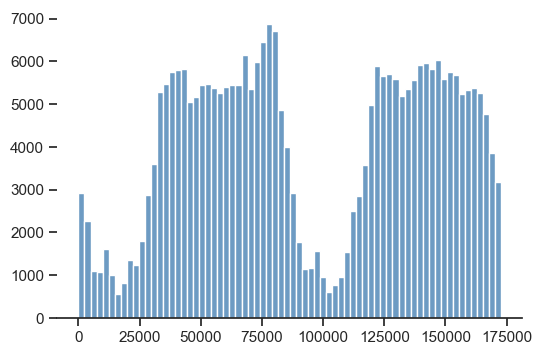

In [8]:
data_raw.time.hist(figsize=(6,4), bins=70, grid=False);

In [9]:
# Create new variable to convert 'time' from seconds to hours
data_raw['time_hrs'] = data_raw['time'] / 3600

In [10]:
# Number of hours
hours = data_raw['time_hrs'].apply(np.floor).astype(int).nunique()

In [11]:
hours

48

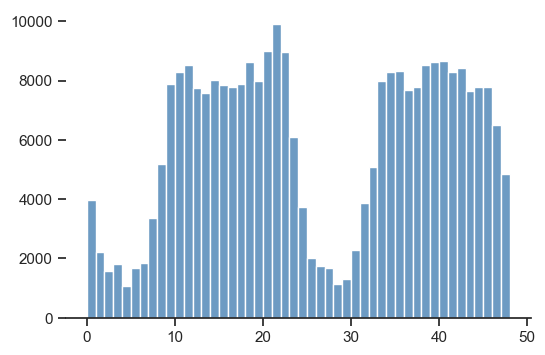

In [12]:
data_raw.time_hrs.hist(figsize=(6,4), bins=48, grid=False);

In [13]:
# Create function to make groups hour-by-hour and find thw lowest frequency of transactions by each hour

def count_transactions (df, variable, hours):

    # List with frequency of transactions by each hour from 0 to 48
    lst = []

    # List with frequency of transactions in first hour
    l = len(df[(df[variable] >= 0) & (df[variable] < 1)])
    
    # Create variable, which contains number of hour with minimal frequency of transactions
    k = 0
    
    for i in range(0, hours):
        
        # Create variable with number of transactions in current hour
        l1 = len(df[(df[variable] >= i) & (df[variable] < (i+1))])
        
        # Append list with number of transactions in current hour
        lst.append(l1)
        
        # Compare list of current hour with previous to find least number of transactions
        if l1 < l:
            k = i
            l = l1
    
    return lst, k

In [14]:
lst, k = count_transactions(data_raw, 'time_hrs', hours)

In [15]:
print(lst)

[3963, 2217, 1576, 1821, 1082, 1681, 1831, 3368, 5179, 7878, 8288, 8517, 7732, 7585, 8029, 7836, 7786, 7882, 8607, 7994, 8980, 9895, 8977, 6082, 3732, 2003, 1752, 1671, 1127, 1309, 2270, 3875, 5097, 7960, 8310, 8339, 7688, 7780, 8541, 8625, 8667, 8284, 8432, 7655, 7776, 7808, 6464, 4856]


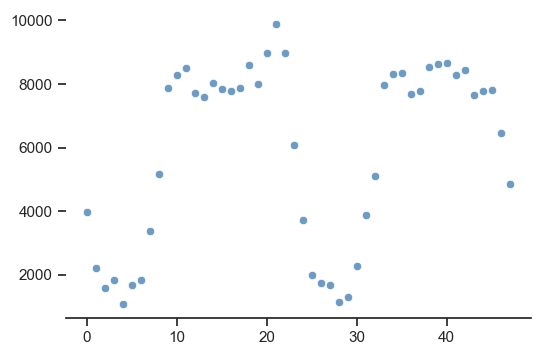

In [16]:
plt.figure(figsize=(6,4))
sns.scatterplot(lst);

In [17]:
# The number of hour since first transaction with minimal frequency of transactions is 4
k

4

In [18]:
# We concluse that 'time_hr'==4 belongs to transactions between 12 a.m. and 1 a.m. 
# and the first transaction of the day will be element:
data_raw.loc[(data_raw['time_hrs'] >= 4)].iloc[0].to_frame().T

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v22,v23,v24,v25,v26,v27,v28,amount,class,time_hrs
9577,14403.0,1.225954,0.425951,0.892547,0.943333,-0.605162,-1.234733,0.027089,-0.359107,1.190186,...,-0.776764,0.205764,0.870309,0.146231,0.020651,-0.050668,0.019507,1.98,0.0,4.000833


In [19]:
# Elemnts with 'time_hr'==k are transactions in the first hour, so lets subtract k from every value in 'time_hr'
data_raw['time_hrs'] = data_raw['time_hrs'] - k

In [20]:
# Now transform values less than 0. For example, "-4" in this values means less than 24 by 4
data_raw.loc[data_raw['time_hrs'] < 0, 'time_hrs'] = \
    data_raw.loc[data_raw['time_hrs'] < 0, 'time_hrs'] + 24

# And also transform values more than 24. For example, "34" in this values means more than 24 by 10
data_raw.loc[data_raw['time_hrs'] >= 24 , 'time_hrs'] = \
    data_raw.loc[data_raw['time_hrs'] >= 24 , 'time_hrs'] - 24

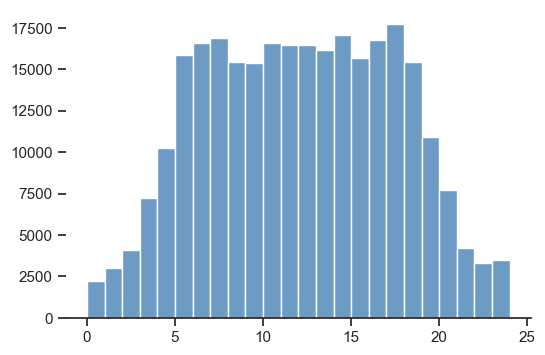

In [21]:
data_raw['time_hrs'].hist(figsize=(6, 4), bins=24, grid=False);

In [22]:
# Create variable with transactions during night (time less than 6 hours)
data_raw['tx_during_night'] = (data_raw['time_hrs']<=6).astype(int)

In [23]:
# Creating datetime

# Reference random start point
start = dt.datetime(2015,5,15,0,0)

# Delta, as we know that first transaction was made at 20:00
delta = dt.timedelta(hours=20)

# Addind new variable
data_raw['time_datetime'] = data_raw['time'].astype('timedelta64[s]') + start + delta
# data_raw['time_datetime'] = data_raw['time_datetime'].dt.time

In [24]:
data_raw

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v24,v25,v26,v27,v28,amount,class,time_hrs,tx_during_night,time_datetime
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,20.000000,0,2015-05-15 20:00:00
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,20.000000,0,2015-05-15 20:00:00
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,20.000278,0,2015-05-15 20:00:01
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,20.000278,0,2015-05-15 20:00:01
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,20.000556,0,2015-05-15 20:00:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,19.996111,0,2015-05-17 19:59:46
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,19.996389,0,2015-05-17 19:59:47
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,19.996667,0,2015-05-17 19:59:48
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,19.996667,0,2015-05-17 19:59:48


In [25]:
data_raw.iloc[9577].to_frame().T

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v24,v25,v26,v27,v28,amount,class,time_hrs,tx_during_night,time_datetime
9577,14403.0,1.225954,0.425951,0.892547,0.943333,-0.605162,-1.234733,0.027089,-0.359107,1.190186,...,0.870309,0.146231,0.020651,-0.050668,0.019507,1.98,0,0.000833,1,2015-05-16 00:00:03


### Train Test Split

In [26]:
train_size = round(0.85 * len(data_raw))

In [27]:
train_size

242086

In [28]:
test_size = len(data_raw) - train_size

In [29]:
test_size

42721

In [30]:
valid_size = round(0.2 * train_size)

In [31]:
valid_size

48417

In [32]:
train_size = train_size - valid_size

In [33]:
len(data_raw) - train_size - test_size - valid_size

0

In [34]:
data_train = data_raw[:train_size]
data_valid = data_raw[train_size:(len(data_raw) - test_size)]
data_test = data_raw[(len(data_raw) - test_size):]

In [35]:
data_train.shape

(193669, 34)

In [36]:
data_valid.shape

(48417, 34)

In [37]:
data_test.shape

(42721, 34)

In [38]:
len(data_valid) / len(data_train)

0.24999870913775565

In [39]:
len(data_test) / len(data_train)

0.22058770376260528

In [40]:
data_raw.shape[0] - (data_train.shape[0] + data_valid.shape[0] + data_test.shape[0])

0

In [41]:
x_train = data_train.drop('class', axis=1)
y_train = data_train['class']

x_valid = data_valid.drop('class', axis=1)
y_valid = data_valid['class']

x_test = data_test.drop('class', axis=1)
y_test = data_test['class']

In [42]:
x_train

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v23,v24,v25,v26,v27,v28,amount,time_hrs,tx_during_night,time_datetime
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,20.000000,0,2015-05-15 20:00:00
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,20.000000,0,2015-05-15 20:00:00
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,20.000278,0,2015-05-15 20:00:01
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,20.000278,0,2015-05-15 20:00:01
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,20.000556,0,2015-05-15 20:00:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193664,130237.0,-1.685392,1.527428,-0.176295,-0.694380,0.652041,0.528847,0.439253,0.635049,0.229310,...,0.093038,-1.129782,-0.574839,0.291997,-0.237884,-0.252154,8.95,8.176944,0,2015-05-17 08:10:37
193665,130238.0,-0.563066,0.480017,1.629283,-1.070801,-0.153443,-0.846233,0.784647,-0.020859,0.255744,...,0.213485,0.362225,-0.802199,-0.309651,0.116582,0.189614,49.99,8.177222,0,2015-05-17 08:10:38
193666,130238.0,-0.687893,-1.277033,1.965504,-2.477239,0.755970,-0.318740,-2.702989,-0.566589,-0.011666,...,-3.352984,0.252396,0.615660,1.232181,0.110158,0.243291,164.90,8.177222,0,2015-05-17 08:10:38
193667,130238.0,1.857222,-0.648038,-2.338015,-1.081240,1.142644,0.844196,0.206245,0.145262,0.547588,...,0.034167,-0.623844,0.022732,0.836282,-0.078954,-0.089937,76.86,8.177222,0,2015-05-17 08:10:38


## Data Overview

### Functions

In [43]:
def df_values(df):
    
    return pd.concat([df.dtypes.rename('Type').to_frame(),
                      df.count().rename('Count').to_frame(),
                      df.nunique().rename('Unique'),
                      df.isnull().sum().rename('Missing').to_frame()], axis=1)

def balance(df, tar_list, o=2):
    
    plt.figure(figsize=(2.5, 2.5))
    sns.countplot(data=df, x=tar_list[0])
    plt.show()

    print('Total: {}'.format(df.loc[df[tar_list[0]] == 1, tar_list[0]].count() +
                             df.loc[df[tar_list[0]] == 0, tar_list[0]].count()), '\n')

    print(f'Positive: {df.loc[df[tar_list[0]] == 1, tar_list[0]].count()}')
    print(f'Negative: {df.loc[df[tar_list[0]] == 0, tar_list[0]].count()}', '\n')

    print('Positive / Negative: {}'.format(
        round(df.loc[df[tar_list[0]] == 1, tar_list[0]].count() /
              df.loc[df[tar_list[0]] == 0, tar_list[0]].count(), o)))

### Dataset

In [44]:
x_train

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v23,v24,v25,v26,v27,v28,amount,time_hrs,tx_during_night,time_datetime
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,20.000000,0,2015-05-15 20:00:00
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,20.000000,0,2015-05-15 20:00:00
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,20.000278,0,2015-05-15 20:00:01
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,20.000278,0,2015-05-15 20:00:01
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,20.000556,0,2015-05-15 20:00:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193664,130237.0,-1.685392,1.527428,-0.176295,-0.694380,0.652041,0.528847,0.439253,0.635049,0.229310,...,0.093038,-1.129782,-0.574839,0.291997,-0.237884,-0.252154,8.95,8.176944,0,2015-05-17 08:10:37
193665,130238.0,-0.563066,0.480017,1.629283,-1.070801,-0.153443,-0.846233,0.784647,-0.020859,0.255744,...,0.213485,0.362225,-0.802199,-0.309651,0.116582,0.189614,49.99,8.177222,0,2015-05-17 08:10:38
193666,130238.0,-0.687893,-1.277033,1.965504,-2.477239,0.755970,-0.318740,-2.702989,-0.566589,-0.011666,...,-3.352984,0.252396,0.615660,1.232181,0.110158,0.243291,164.90,8.177222,0,2015-05-17 08:10:38
193667,130238.0,1.857222,-0.648038,-2.338015,-1.081240,1.142644,0.844196,0.206245,0.145262,0.547588,...,0.034167,-0.623844,0.022732,0.836282,-0.078954,-0.089937,76.86,8.177222,0,2015-05-17 08:10:38


In [45]:
df_values(x_train).T

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v23,v24,v25,v26,v27,v28,amount,time_hrs,tx_during_night,time_datetime
Type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,int64,datetime64[ns]
Count,193669,193669,193669,193669,193669,193669,193669,193669,193669,193669,...,193669,193669,193669,193669,193669,193669,193669,193669,193669,193669
Unique,87482,187987,187987,187987,187987,187987,187987,187987,187987,187987,...,187987,187987,187987,187987,187987,187987,27181,81052,2,87482
Missing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
x_train.describe()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v22,v23,v24,v25,v26,v27,v28,amount,time_hrs,tx_during_night
count,193669.000000,193669.000000,193669.000000,193669.000000,193669.000000,193669.000000,193669.000000,193669.000000,193669.000000,193669.000000,...,193669.000000,193669.000000,193669.000000,193669.000000,193669.000000,193669.000000,193669.000000,193669.000000,193669.000000,193669.000000
mean,68646.921345,-0.116417,0.007507,0.351810,0.084308,-0.123974,0.049194,-0.057074,0.020772,0.010610,...,-0.054018,-0.017202,0.004957,0.066648,0.007405,0.001315,0.002146,89.477089,11.332565,0.220268
std,33351.725647,1.887522,1.620991,1.438987,1.395726,1.358006,1.307625,1.214367,1.211168,1.138404,...,0.687068,0.607907,0.603030,0.486441,0.489001,0.394064,0.312348,248.536661,5.932000,0.414428
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,...,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000,0.000000
25%,43633.000000,-0.966145,-0.576441,-0.284283,-0.783661,-0.792911,-0.706488,-0.579035,-0.177565,-0.662867,...,-0.539312,-0.169013,-0.340063,-0.232585,-0.331155,-0.067108,-0.039746,5.990000,6.345278,0.000000
50%,65956.000000,-0.105569,0.084390,0.517053,0.085234,-0.180922,-0.214978,-0.015219,0.045627,-0.074862,...,-0.040379,-0.030174,0.053778,0.109853,-0.060563,0.006451,0.018929,22.900000,10.491667,0.000000
75%,86763.000000,1.208049,0.784549,1.237919,0.898543,0.448367,0.446609,0.492443,0.340670,0.629024,...,0.412742,0.112320,0.420613,0.387154,0.263908,0.089120,0.078228,79.000000,16.485556,0.000000
max,130238.000000,2.454930,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,15.594995,...,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,23.999444,1.000000


In [47]:
len(x_train.columns)

33

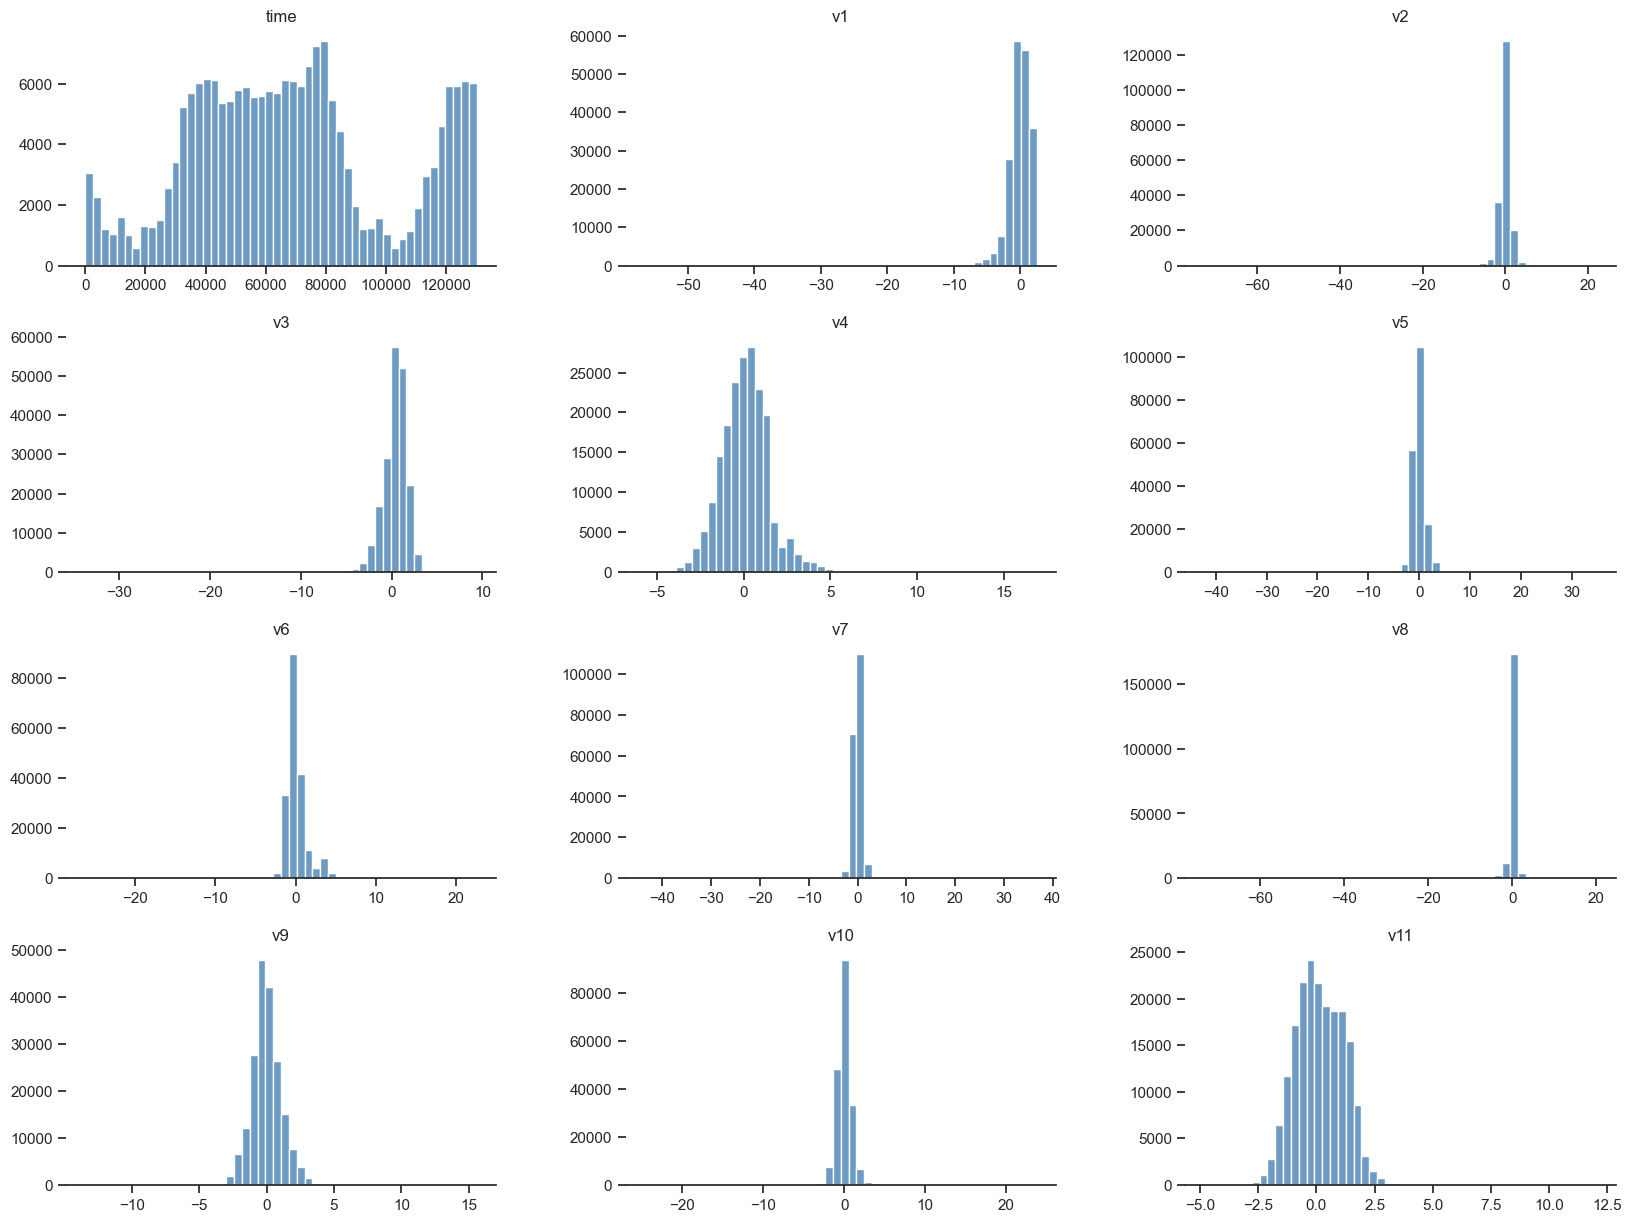

In [48]:
x_train.iloc[:,:12].hist(figsize=(20, 15), bins=50, grid=False);

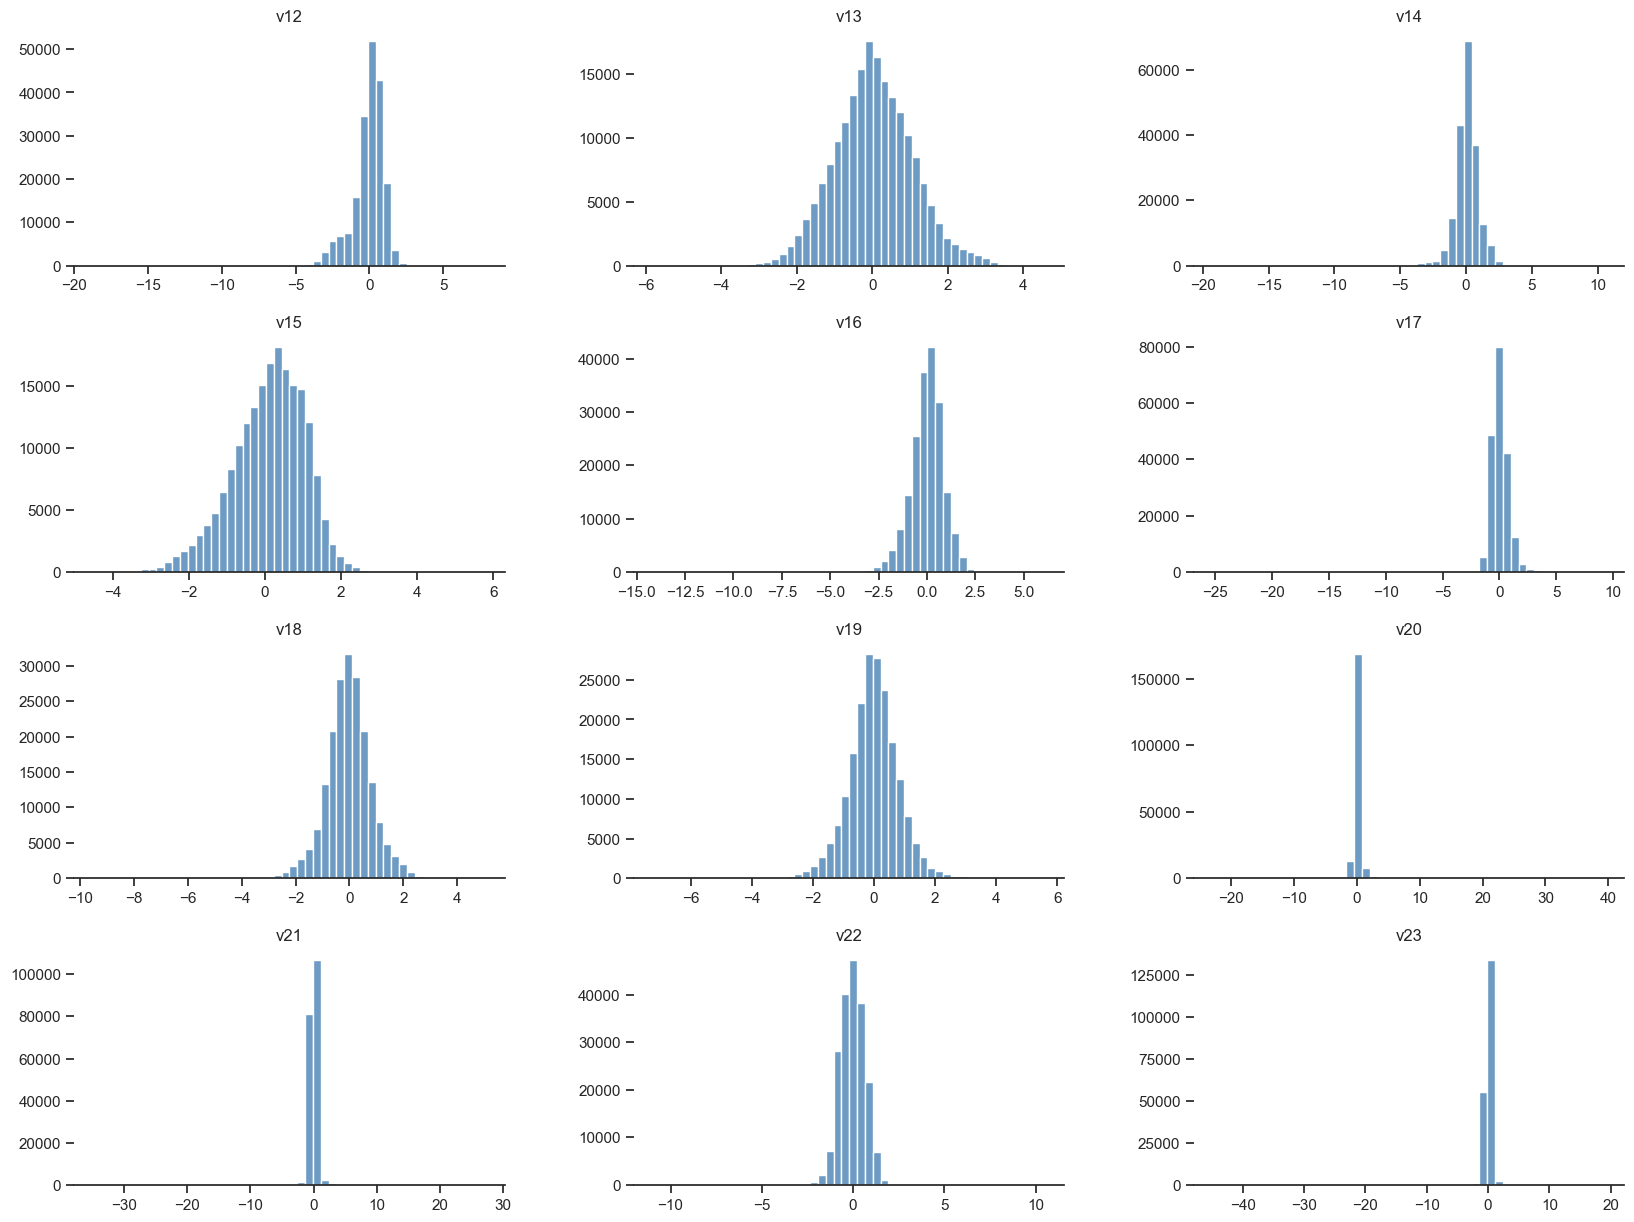

In [49]:
x_train.iloc[:,12:24].hist(figsize=(20, 15), bins=50, grid=False);

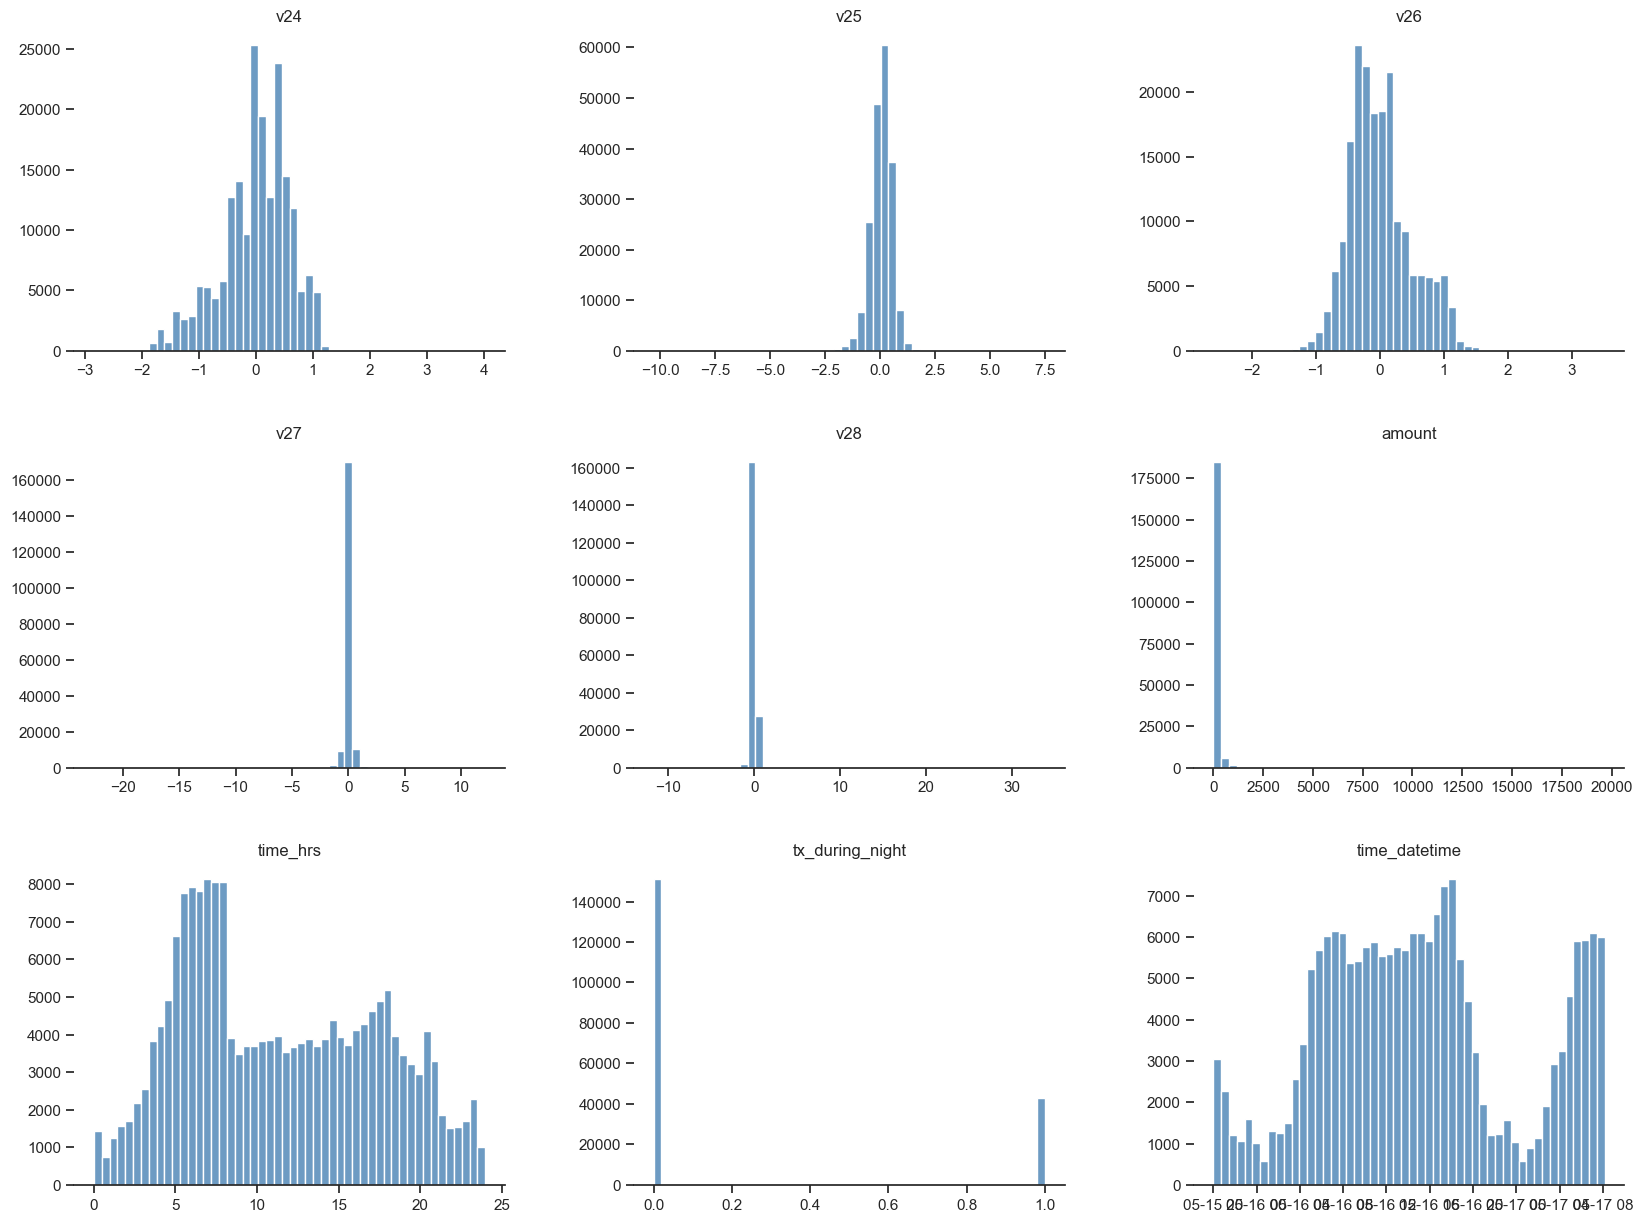

In [50]:
x_train.iloc[:,24:34].hist(figsize=(20, 15), bins=50, grid=False);

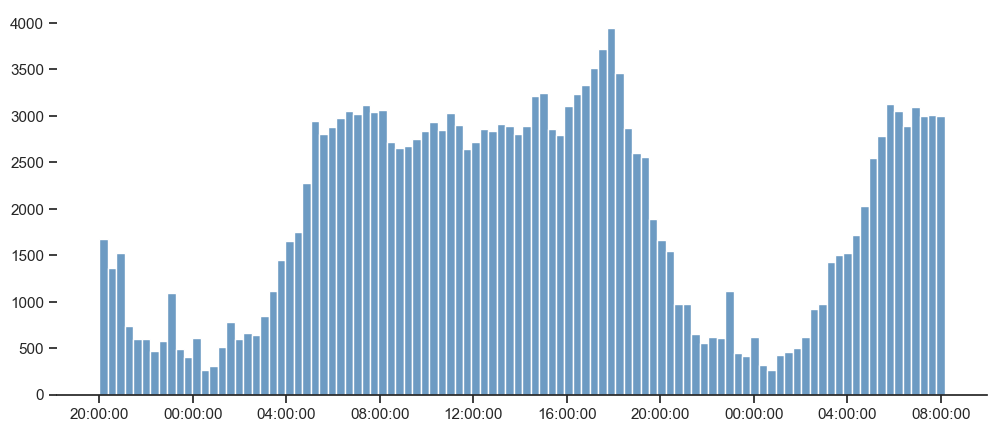

In [51]:
ax = x_train['time_datetime'].hist(figsize=(12,5), bins=100, grid=False);
myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)

### Balance

In [52]:
tar_list = ['class']

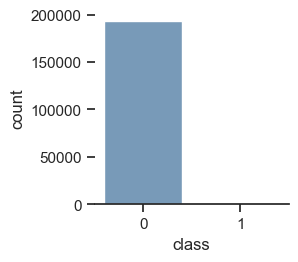

Total: 193669 

Positive: 381
Negative: 193288 

Positive / Negative: 0.00197


In [53]:
balance(data_train, tar_list, 5)

### Choosing Better Variables With Logistic Regression

In [54]:
def cl_report(y_test, y_pred, name=None):

    cl_report_df = classification_report(y_test,
                                         y_pred,
                                         target_names=['0', '1'],
                                         output_dict=True)

    plt.subplots(figsize=(6.5, 2.2))
    sns.heatmap(pd.DataFrame(cl_report_df).iloc[:-1, :].T,
                cmap=report,
                annot_kws={'size': 9.5},
                cbar_kws={'shrink': 1},
                annot=True,
                xticklabels=['Precision', 'Recall', 'F1-Score'],
                yticklabels=['HD: 0', 'HD: 1', 'Accuracy', 'Macro Avg', 'Weighted Avg'],
                vmin=0.85, vmax=0.95)

    plt.xticks(size=9)
    plt.yticks(size=9)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    plt.show()
    

def conf_matrix(y, y_pred):

    fig, ax = plt.subplots(figsize=(6.5, 1.5))

    ax = sns.heatmap(confusion_matrix(y, y_pred),
                     cmap=con_matrix,
                     annot_kws={'size': 12},
                     cbar_kws={'shrink': 1},
                     annot=True,
                     xticklabels=['NO', 'YES'],
                     yticklabels=['NO', 'YES'],
                     cbar=False,
                     fmt='g')

    plt.xticks(size=9)
    plt.yticks(size=9)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.title('Confusion Matrix', fontsize=15, y=1.1)

    ax.set_ylabel('Test', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)

    plt.show()

In [55]:
predictors_list = x_train.drop(['time', 'time_hrs', 'time_datetime'], axis=1).columns

In [56]:
predictors_list

Index(['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11',
       'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21',
       'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'tx_during_night'],
      dtype='object')

In [57]:
predictors = [x for x in predictors_list if x not in ['v1', 'v2', 'v3', 'v5', 'v6', 'v7', 'v9', \
                                                      'v11', 'v12', 'v15', 'v16', 'v17', 'v18', \
                                                      'v19', 'v24', 'v25', 'amount']]

In [58]:
print(predictors)

['v4', 'v8', 'v10', 'v13', 'v14', 'v20', 'v21', 'v22', 'v23', 'v26', 'v27', 'v28', 'tx_during_night']


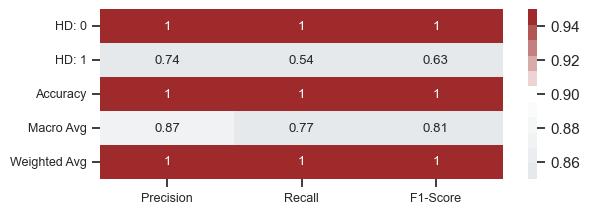

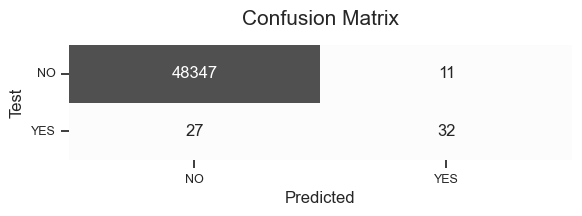

In [59]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(x_train[predictors], y_train)

m = clf.predict(x_valid[predictors])

cl_report(y_valid, m)

conf_matrix(y_valid, m)

In [60]:
pd.concat([pd.DataFrame(predictors, columns=['Predictors']), \
           pd.DataFrame(clf.coef_).T.rename(columns={0: 'Coeff'})], axis=1)

,Predictors,Coeff
0,v4,0.647220
1,v8,-0.149022
2,v10,-0.729379
3,v13,-0.306239
4,v14,-0.591215
5,v20,-0.208996
6,v21,0.393626
7,v22,0.592092
8,v23,-0.113314
9,v26,0.309155


In [61]:
clf_pred_proba = clf.predict_proba(x_valid[predictors])

In [62]:
def threshold_range(y_test, y, lower=0.2, upper=0.5, step=0.05, kind='prob'):

    arr = np.arange(lower, upper, step)
    df = pd.DataFrame(columns=['threshold', 'precision', 'recall', 'f1_score'])

    if kind == 'prob':
        
        for i in arr:
            y_pred_lower_threshold = np.where(y[:, 1] >= i, 1, 0)
            p = precision_score(y_test, y_pred_lower_threshold).round(2)
            r = recall_score(y_test, y_pred_lower_threshold).round(2)
            f1 = f1_score(y_test, y_pred_lower_threshold).round(2)

            l = [i, p, r, f1]
            df.loc[len(df)] = l
        
        return df

    if kind == 'func':
        
        for i in arr:
            y_pred_lower_threshold = np.where(y >= i, 1, 0)
            p = precision_score(y_test, y_pred_lower_threshold).round(2)
            r = recall_score(y_test, y_pred_lower_threshold).round(2)
            f1 = f1_score(y_test, y_pred_lower_threshold).round(2)

            j = round(i, 4)

            l = [j, p, r, f1]
            df.loc[len(df)] = l
            
        return df

In [63]:
threshold_range(y_valid, clf_pred_proba, lower=0.0, upper=0.5, step=0.05, kind='prob')

,threshold,precision,recall,f1_score
0,0.00,0.00,1.00,0.00
1,0.05,0.50,0.85,0.62
2,0.10,0.66,0.85,0.74
3,0.15,0.71,0.78,0.74
4,0.20,0.73,0.69,0.71
5,0.25,0.72,0.64,0.68
6,0.30,0.71,0.63,0.67
7,0.35,0.71,0.59,0.65
8,0.40,0.70,0.56,0.62
9,0.45,0.72,0.56,0.63


In [64]:
threshold = 0.15

In [65]:
y_pred_lr = (clf_pred_proba[:, 1] >= threshold).astype('int')

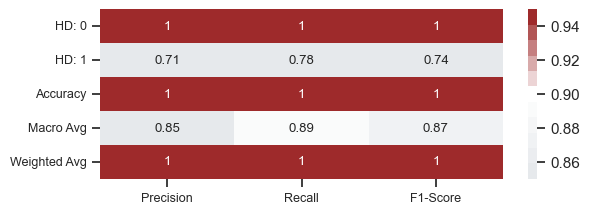

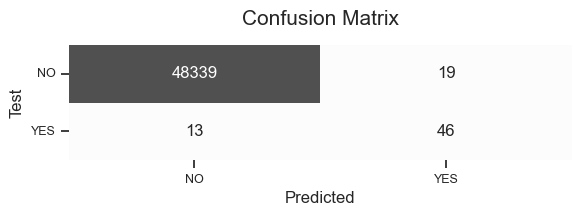

In [66]:
cl_report(y_valid, y_pred_lr)

conf_matrix(y_valid, y_pred_lr)

## Neural Network

In [67]:
def model_nn(layers, neurons, lr=0.001, drop=0.2, input_shape=None):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape,
                                    name='input'))

    for layer in range(layers):
        model.add(tf.keras.layers.Dense(units=neurons,
                                        activation='selu'))
        model.add(tf.keras.layers.Dropout(drop))

    model.add(tf.keras.layers.Dense(units=1,
                                    activation='sigmoid',
                                    name='output'))

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.Recall()])

    return model


def dnn_ev_plot(history):

    pd.DataFrame(history.history).plot(figsize=(10, 6))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()


def nn_fit(model, x_train, y_train, last=False, graph=False, early_stopping=None):

    history = model.fit(x_train,
                        y_train,
                        epochs=500,
                        validation_split=0.2,
                        verbose=0,
                        callbacks=early_stopping)

    if last is False:
        display(pd.DataFrame(history.history))
    else:
        display(pd.DataFrame(history.history).iloc[[-1]])
    if graph is True:
        dnn_ev_plot(history)

In [68]:
input_shape = x_train[predictors].shape[1:]

In [69]:
input_shape

(13,)

In [70]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0,
    restore_best_weights=True
)

params = {'layers': 2,
          'neurons': 40,
          'lr': 0.001,
          'drop': 0,
          'input_shape': input_shape}

In [71]:
def reset_seeds(seed):

    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

,loss,recall,val_loss,val_recall
14,0.002724,0.808023,0.003713,0.75


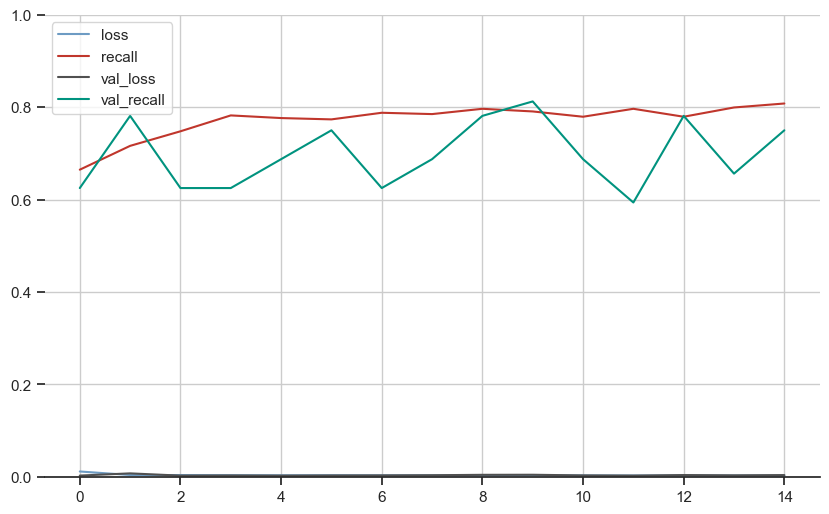

Training time: 0:03:42 

1514/1514 [==============================] - 3s 2ms/step
Prediction time: 0:00:04 



In [72]:
reset_seeds(seed)

nn = model_nn(**params)

tr_start = time.time()

nn_fit(nn,
       x_train[predictors],
       y_train,
       last=True,
       graph=True,
       early_stopping=early_stopping)

tr_end = time.time()
tr_time = str(dt.timedelta(seconds=np.round(tr_end - tr_start)))
print('Training time: {}'.format(tr_time), '\n')

pr_start = time.time()

y_pred_prob_nn = np.concatenate(nn.predict(x_valid[predictors]))
y_pred_nn = np.array([round(float(i), 0) for i in y_pred_prob_nn])

pr_end = time.time()
pr_time = str(dt.timedelta(seconds=np.round(pr_end - pr_start)))
print('Prediction time: {}'.format(pr_time), '\n')

In [73]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                560       
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 output (Dense)              (None, 1)                 41        
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


## Precision-Recall Trade-off

In [74]:
def prec_rec(y_test, y_pred, y_pred_prob):

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    # calculate f_score
    f = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f_score
    x = np.argmax(f)
    # calculate best recall, precision
    precision_opt = round(precision[x], 2)
    recall_opt = round(recall[x], 2)
    threshold_opt = round(thresholds[x], 2)

    plt.figure(figsize=(6, 4))
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=15, y=1.05)

    plt.plot(recall,
             precision)
    plt.plot(recall_opt,
             precision_opt,
             marker='o',
             markersize=10,
             label='Precision-Recall Optimal Threshold',
             fillstyle='none',
             color='k',
             mew=1.7)

    plt.xticks(size=9)
    plt.yticks(size=9)
    plt.legend(loc='best', fontsize=10)
    # plt.savefig('roc_auc.png')
    plt.show()

    return precision_opt, recall_opt, threshold_opt

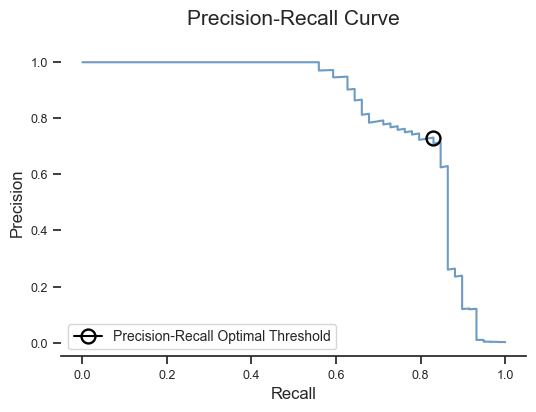

(0.73, 0.83, 0.21)

In [75]:
prec_rec(y_valid, y_pred_nn, y_pred_prob_nn)

In [76]:
threshold_range(y_valid,
                y_pred_prob_nn,
                lower=0.00,
                upper=0.3,
                step=0.01,
                kind='func')

,threshold,precision,recall,f1_score
0,0.00,0.00,1.00,0.00
1,0.01,0.14,0.90,0.25
2,0.02,0.28,0.86,0.43
3,0.03,0.39,0.86,0.54
4,0.04,0.46,0.86,0.60
5,0.05,0.50,0.86,0.64
6,0.06,0.55,0.86,0.67
7,0.07,0.57,0.86,0.69
8,0.08,0.59,0.86,0.70
9,0.09,0.61,0.86,0.72


In [77]:
threshold_nn = 0.15

In [78]:
y_pred_nn = (y_pred_prob_nn > threshold_nn).astype('float64')

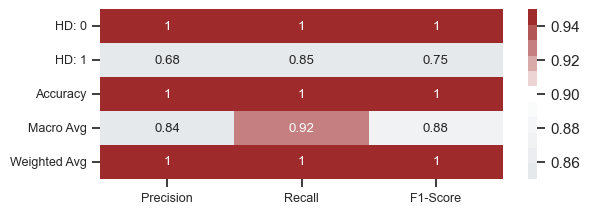

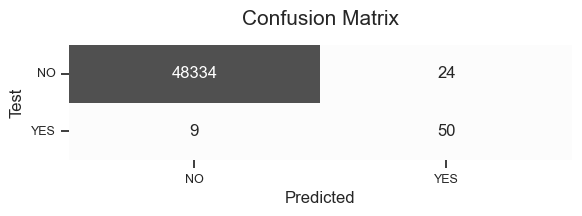

In [79]:
cl_report(y_valid,
          y_pred_nn)

conf_matrix(y_valid, y_pred_nn)